 <center><h2>Comparision of Diffrent Quantization methods for URL Classification</h2></center>

In [1]:
!nvidia-smi

Sun Jul  4 14:18:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8    16W /  N/A |    121MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import os
import pandas as pd
from tensorflow import keras
import numpy as np

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K

In [5]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [6]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [7]:
data = pd.read_csv("feature.csv")

In [8]:
data

,Unnamed: 0,File,bodyLength,bscr,dse,dsr,entropy,hasHttp,hasHttps,has_ip,...,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
0,0,spam_dataset,31,0.064516,0,0,-4.708307,True,False,0,...,0,0,0,0,0.000000,0,2,0.000000,False,81
1,1,spam_dataset,64790,0.306050,0,0,-4.576882,True,False,0,...,0,19,0,0,0.923800,59853,19829,3.018458,False,58
2,2,spam_dataset,757,0.195509,0,0,-4.205536,True,False,0,...,0,1,0,0,0.000000,0,148,0.000000,False,46
3,3,spam_dataset,266310,0.230915,0,0,-4.550931,True,False,0,...,0,648,0,0,0.312647,83261,61495,1.353947,False,52
4,4,spam_dataset,40,0.200000,0,0,-4.689336,True,False,0,...,2,1,0,0,0.000000,0,8,0.000000,False,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54526,9996,Defacement,33,0.121212,0,0,-4.755244,True,False,0,...,5,1,0,0,0.000000,0,4,0.000000,False,155
54527,9997,Defacement,862930,0.207603,0,0,-4.419173,True,False,0,...,0,3,0,0,0.011485,9911,179147,0.055323,False,79
54528,9998,Defacement,183,0.185792,0,0,-4.196164,True,False,0,...,0,1,0,0,0.000000,0,34,0.000000,False,65
54529,9999,Defacement,0,0.000000,0,0,-3.896292,True,False,0,...,0,0,0,0,0.000000,0,0,0.000000,False,28


In [9]:
set(data['File'])

{'Benign_list_big_final',
 'Defacement',
 'Malware_dataset',
 'phishing_dataset',
 'spam_dataset'}

In [10]:
data.replace("Benign_list_big_final","Benign",inplace=True)
data.replace("Malware_dataset","Malware",inplace=True)
data.replace("phishing_dataset","Phishing",inplace=True)
data.replace("spam_dataset","Spam",inplace=True)

In [11]:
data.drop(columns='Unnamed: 0',inplace=True)
data.replace(True,1,inplace = True)
data.replace(False,0,inplace = True)
y = data["File"]

In [12]:
data = data.drop(columns = "File")

In [13]:
encoder = LabelEncoder()
encoder.fit(y)
Y = encoder.transform(y)

In [14]:
set(Y),Y

({0, 1, 2, 3, 4}, array([4, 4, 4, ..., 1, 1, 1]))

In [15]:
encoder.inverse_transform([0,1,2,3,4])

array(['Benign', 'Defacement', 'Malware', 'Phishing', 'Spam'],
      dtype=object)

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))#basic normalisation
X = scaler.fit_transform(data)
X = pd.DataFrame(X)# Fitting back to data Frame
X

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.000017,0.087977,0.259553,0.00008,0.370703,1.0,0.0,0.0,0.059471,0.001558,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000004,0.000000,0.0,0.044128
1,0.035658,0.417341,0.259553,0.00008,0.410333,1.0,0.0,0.0,0.026432,0.009346,...,0.000000,0.018234,0.0,0.0,0.922293,0.033325,0.039119,0.008193,0.0,0.027758
2,0.000417,0.266603,0.259553,0.00008,0.522309,1.0,0.0,0.0,0.000000,0.009346,...,0.000000,0.000960,0.0,0.0,0.000000,0.000000,0.000292,0.000000,0.0,0.019217
3,0.146569,0.314884,0.259553,0.00008,0.418158,1.0,0.0,0.0,0.028634,0.004673,...,0.000000,0.621881,0.0,0.0,0.312137,0.046359,0.121319,0.003675,0.0,0.023488
4,0.000022,0.272727,0.259553,0.00008,0.376423,1.0,0.0,0.0,0.030837,0.000000,...,0.111111,0.000960,0.0,0.0,0.000000,0.000000,0.000016,0.000000,0.0,0.045552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54526,0.000018,0.165289,0.259553,0.00008,0.356549,1.0,0.0,0.0,0.017621,0.000000,...,0.277778,0.000960,0.0,0.0,0.000000,0.000000,0.000008,0.000000,0.0,0.096797
54527,0.474930,0.283095,0.259553,0.00008,0.457889,1.0,0.0,0.0,0.013216,0.003115,...,0.000000,0.002879,0.0,0.0,0.011467,0.005518,0.353425,0.000150,0.0,0.042705
54528,0.000101,0.253353,0.259553,0.00008,0.525135,1.0,0.0,0.0,0.006608,0.000000,...,0.000000,0.000960,0.0,0.0,0.000000,0.000000,0.000067,0.000000,0.0,0.032740
54529,0.000000,0.000000,0.259553,0.00008,0.615560,1.0,0.0,0.0,0.004405,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.006406


In [17]:
print("There are ",len(data.columns),"Columns and they are:\n\n",data.columns)

There are  21 Columns and they are:

 Index(['bodyLength', 'bscr', 'dse', 'dsr', 'entropy', 'hasHttp', 'hasHttps',
       'has_ip', 'numDigits', 'numImages', 'numLinks', 'numParams',
       'numTitles', 'num_%20', 'num_@', 'sbr', 'scriptLength', 'specialChars',
       'sscr', 'urlIsLive', 'urlLength'],
      dtype='object')


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding

input_dim = len(data.columns)
model = Sequential()
model.add(Dense(256, input_dim = input_dim , activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 49,477
Trainable params: 49,477
Non-trainable params: 0
____________________________________________________

In [20]:
X.shape

(54531, 21)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [22]:
history = model.fit(X_train,to_categorical(y_train),epochs = 50,validation_split=0.3, batch_size = 128)

Epoch 1/50
224/224 [==============================] - 5s 11ms/step - loss: 1.3970 - accuracy: 0.4134 - val_loss: 1.0133 - val_accuracy: 0.5954
Epoch 2/50
224/224 [==============================] - 2s 10ms/step - loss: 0.9640 - accuracy: 0.6141 - val_loss: 0.8350 - val_accuracy: 0.6793
Epoch 3/50
224/224 [==============================] - 2s 7ms/step - loss: 0.8272 - accuracy: 0.6721 - val_loss: 0.7573 - val_accuracy: 0.7090
Epoch 4/50
224/224 [==============================] - 2s 8ms/step - loss: 0.7682 - accuracy: 0.6953 - val_loss: 0.7663 - val_accuracy: 0.6985
Epoch 5/50
224/224 [==============================] - 2s 7ms/step - loss: 0.7062 - accuracy: 0.7202 - val_loss: 0.6596 - val_accuracy: 0.7465
Epoch 6/50
224/224 [==============================] - 2s 8ms/step - loss: 0.6780 - accuracy: 0.7375 - val_loss: 0.6511 - val_accuracy: 0.7544
Epoch 7/50
224/224 [==============================] - 2s 7ms/step - loss: 0.6305 - accuracy: 0.7560 - val_loss: 0.6095 - val_accuracy: 0.7708
Epoc

In [23]:
import matplotlib.pyplot as plt

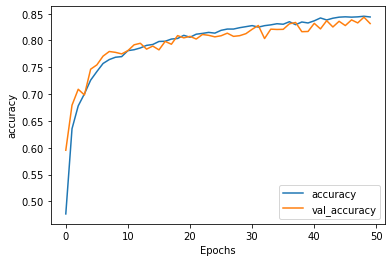

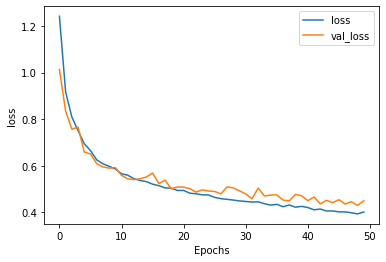

In [24]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
y_pred = model.predict(X_test)
y_pred

array([[9.9971002e-01, 8.7089909e-08, 1.4047509e-09, 2.8987604e-04,
        1.3787318e-13],
       [6.1271089e-04, 1.1115680e-01, 7.9697073e-01, 4.9971957e-02,
        4.1287787e-02],
       [1.3561847e-10, 7.9358488e-01, 2.7291460e-06, 1.6111873e-01,
        4.5293640e-02],
       ...,
       [2.9213342e-01, 2.8734014e-03, 7.0496231e-01, 3.0234693e-05,
        5.5907037e-07],
       [9.9402690e-01, 3.2269664e-03, 1.4194794e-03, 1.3210578e-03,
        5.7032280e-06],
       [3.6554079e-06, 9.8662042e-08, 1.8332331e-10, 4.9529768e-07,
        9.9999571e-01]], dtype=float32)

In [26]:
predicted = np.argmax(y_pred, axis=1)
predicted

array([0, 2, 1, ..., 2, 0, 4], dtype=int64)

In [27]:
from sklearn.metrics import classification_report
print("Test Accuracy of Base Keras Model: ",accuracy_score(y_test,predicted))

Test Accuracy of Base Keras Model:  0.8406807012396391


In [28]:
target_names = ['Benign','Defacement','Malware','Phishing','Spam']
print(classification_report(y_test, predicted, target_names=target_names))

              precision    recall  f1-score   support

      Benign       0.92      0.96      0.94      2735
  Defacement       0.80      0.70      0.75      2499
     Malware       0.83      0.89      0.86      2834
    Phishing       0.85      0.70      0.77      2477
        Spam       0.80      0.91      0.85      3088

    accuracy                           0.84     13633
   macro avg       0.84      0.83      0.83     13633
weighted avg       0.84      0.84      0.84     13633



In [29]:
KERAS_MODEL_NAME = "tf_model_URL_Clasification.h5"

In [30]:
model.save(KERAS_MODEL_NAME)

In [31]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

File size: 635.387 Kilobytes


In [32]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 0.62 Megabytes


<h1> <u>TF Lite MODEL</u></h1>

Here We are createing a TFLite model using post Quantization technique

<h1> 1) <u>Dynamic range quantization</u></h1>

In [32]:
TF_LITE_MODEL_FILE_NAME_dynamic = "tf_lite_model_dynamic.tflite"

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_Dynamic = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\phvpa\AppData\Local\Temp\tmpe6zlmpos\assets


In [34]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME_dynamic
open(tflite_model_name, "wb").write(tflite_model_Dynamic)

56096

In [35]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME_dynamic), "KB")

File size: 54.781 Kilobytes


## Check Input Tensor Shape

In [36]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME_dynamic) # By creating inpterpreter we are getting i/p and o/p detailes
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Resize Tensor Shape

In [37]:
#By using the resize_tensor_input we are passing the new dimmension we want to input
interpreter.resize_tensor_input(input_details[0]['index'], (13633, 21))
interpreter.resize_tensor_input(output_details[0]['index'], (13633, 5))
#allocate_tensor() object for the interpreter object
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [38]:
test_urls_numpy = np.array(X_test, dtype=np.float32)

In [39]:
interpreter.set_tensor(input_details[0]['index'], test_urls_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (13633, 5)


In [40]:
acc = accuracy_score(prediction_classes, y_test)
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.8121469962590773


<h1> 2) <u> Integer only Quantisation</u></h1>

Here We are createing a TFLite model using post Quantization technique

In [33]:
TF_LITE_MODEL_FILE_NAME_intonly = "tf_lite_model_intonly.tflite"

In [35]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((X_train)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]


tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.data = data
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tf_lite_converter.representative_dataset = representative_dataset
tf_lite_converter.inference_input_type = tf.uint8#Error is from this line and
tf_lite_converter.inference_output_type = tf.uint8#Error is from this line also
#If we comment this two lines and run then will get our outputs
tflite_model_Integer = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\phvpa\AppData\Local\Temp\tmpag_vwzq0\assets


INFO:tensorflow:Assets written to: C:\Users\phvpa\AppData\Local\Temp\tmpag_vwzq0\assets


AttributeError: module 'tensorflow.lite.python.schema_py_generated' has no attribute 'Model'

In [43]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME_intonly
open(tflite_model_name, "wb").write(tflite_model_Integer)

55424

In [44]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME_intonly), "KB")

File size: 54.125 Kilobytes


# Checking Input Tensor shape

In [45]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME_intonly) # By creating inpterpreter we are getting i/p and o/p detailes
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Output Shape:", output_details[0]['shape'])

Input Shape: [ 1 21]
Output Shape: [1 5]


# Resize Tensor Shape

In [46]:
#By using the resize_tensor_input we are passing the new dimmension we want to input
interpreter.resize_tensor_input(input_details[0]['index'], (13633, 21))
interpreter.resize_tensor_input(output_details[0]['index'], (13633, 5))
#allocate_tensor() object for the interpreter object
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()#Input tensor is used for loading the input data
output_details = interpreter.get_output_details()#Output tensor is used for getting predictions
#we are printing the details which are there.
print("Input Shape:", input_details[0]['shape'])
print("Output Shape:", output_details[0]['shape'])

Input Shape: [13633    21]
Output Shape: [13633     5]


In [47]:
#SO here we are converting that float 64 to float 32 which we have achived by this peace of code
test_url_numpy = np.array(X_test, dtype=np.float32)# basicaly creating a new array and specifying the required type that's it

In [48]:
interpreter.set_tensor(input_details[0]['index'], test_url_numpy) 
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (13633, 5)


In [49]:
acc = accuracy_score(prediction_classes, y_test)
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.8139074304995232


<h1>3) <u>Fall back quantisation</u></h1>

In [50]:
TF_LITE_MODEL_FILE_NAME_Fullint = "tf_lite_model_Fullint.tflite"

In [51]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((X_train)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]
    

    
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS,tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.float32

converter.representative_dataset = representative_dataset
tflite_model_Full_Integer = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\phvpa\AppData\Local\Temp\tmpajk2jjco\assets


INFO:tensorflow:Assets written to: C:\Users\phvpa\AppData\Local\Temp\tmpajk2jjco\assets


In [52]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME_Fullint
open(tflite_model_name, "wb").write(tflite_model_Full_Integer)

55424

In [53]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME_Fullint), "KB")

File size: 54.125 Kilobytes


<h2> Checking Input Tensor shape</h2>

In [54]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME_Fullint) # By creating inpterpreter we are getting i/p and o/p detailes
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 21]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


## Resize Tensor Shape

In [55]:
#By using the resize_tensor_input we are passing the new dimmension we want to input
interpreter.resize_tensor_input(input_details[0]['index'], (13633, 21))
interpreter.resize_tensor_input(output_details[0]['index'], (13633, 5))
#allocate_tensor() object for the interpreter object
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
#we are printing the details which are there.
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [13633    21]
Input Type: <class 'numpy.float32'>
Output Shape: [13633     5]
Output Type: <class 'numpy.float32'>


In [56]:
X_test[0].dtype # Our test data is of the type float64

dtype('float64')

In [57]:
#SO here we are converting that float 64 to float 32 which we have achived by this peace of code
test_imgs_numpy = np.array(X_test, dtype=np.float32)# basicaly creating a new array and specifying the required type that's it

In [58]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (13633, 5)


In [59]:
test_imgs_numpy[0].dtype

dtype('float32')

In [60]:
acc = accuracy_score(prediction_classes, y_test)
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.8139074304995232


<h1>4)<u>Float 16 Quantization </u></h1>

In [61]:
TF_LITE_MODEL_FILE_NAME_F16 = "tf_lite_model_F16.tflite"

In [62]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tf_lite_converter.target_spec.supported_types = [tf.float16] #F16
tflite_model_F16 = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\phvpa\AppData\Local\Temp\tmpr0dhwxse\assets


INFO:tensorflow:Assets written to: C:\Users\phvpa\AppData\Local\Temp\tmpr0dhwxse\assets


In [63]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME_F16
open(tflite_model_name, "wb").write(tflite_model_F16)

103632

In [64]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME_F16), "KB")

File size: 101.203 Kilobytes


<h2> Check Input Tensor Shape </h2>

In [65]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME_F16) # By creating inpterpreter we are getting i/p and o/p detailes
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Output Shape:", output_details[0]['shape'])


Input Shape: [ 1 21]
Output Shape: [1 5]


<h2>Resize Tensor Shape</h2>


In [66]:
#By using the resize_tensor_input we are passing the new dimmension we want to input
interpreter.resize_tensor_input(input_details[0]['index'], (13633, 21))
interpreter.resize_tensor_input(output_details[0]['index'], (13633, 5))
#allocate_tensor() object for the interpreter object
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
#we are printing the details which are there.
print("Input Shape:", input_details[0]['shape'])
print("Output Shape:", output_details[0]['shape'])

Input Shape: [13633    21]
Output Shape: [13633     5]


In [67]:
test_url_numpy = np.array(X_test, dtype=np.float32)

In [68]:
interpreter.set_tensor(input_details[0]['index'], test_url_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (13633, 5)


In [69]:
acc = accuracy_score(prediction_classes, y_test)

In [70]:
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.8328320985843175


# <b><u>Inference</u>:</b>

<img src="Results.png" alt="Drawing" style="width: 1000px;"/>

## Get Weights of Keras Model

In [71]:
from sys import getsizeof

In [72]:
getsizeof(model.get_weights()[0][0][0])

28

In [73]:
model.get_weights()[0].shape,model.get_weights()[1].shape,model.get_weights()[2].shape,model.get_weights()[3].shape,model.get_weights()[4].shape

((21, 256), (256,), (256, 128), (128,), (128, 64))

## Access Quantized Weights of TFLite

In [74]:
import h5py

In [75]:
# creating the h5 file to save the weights in tflite model and acces them back
TF_LITE_WEIGHTS_TEMP_FILE_f16 = "temp_weights_from_tflite_f16.h5"

In [76]:
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME_F16)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
all_layers_details = interpreter.get_tensor_details() 
f = h5py.File(TF_LITE_WEIGHTS_TEMP_FILE_f16, "w")   
for layer in all_layers_details:
     grp = f.create_group(str(layer['index']))
     grp.attrs["name"] = layer['name']
     grp.attrs["shape"] = layer['shape']
     grp.attrs["quantization"] = layer['quantization']
     grp.create_dataset("weights", data=interpreter.get_tensor(layer['index']))
f.close()
# Till now my weigths of TFlite model are saved in the h5 file I have created above 

In [77]:
temp_file = h5py.File(TF_LITE_WEIGHTS_TEMP_FILE_f16, 'r')# here we are loading the weights back 
# and here we are showing the value of one of the weights we loaded 
print(temp_file["1"]["weights"][0], type(temp_file["1"]["weights"][0]))

0.01069 <class 'numpy.float16'>


In [78]:
quantized_weight_var = np.array([temp_file["0"]["weights"][0]],dtype = np.float16)

In [79]:
getsizeof(quantized_weight_var[0]),quantized_weight_var[0]

(96,
 array([ 0.,  0., nan, nan,  0., inf, inf, inf,  0., inf,  0.,  0., inf,
        inf,  0., inf,  0.,  0.,  0., inf,  0.], dtype=float16))

In [80]:
temp_file.close()